# EarthGAN: Can we visualize the Earth's mantle convection using a surrogate model?
> Can a surrogate model of the Earth’s Mantle Convection data set be built such that it can be readily run in a web-browser and produce high-fidelity results? We're trying to do just that through the use of a generative adversarial network -- we call ours EarthGAN. We are in active research.

This notebook takes a trained generator from the EarthGAN and uses it to output "fake" Earth mantle convection samples. Of course, this work is still in active research, so results may vary!

# Background



If you are in a Google Colab environment, run the below to clone the EarthGAN repo into the colab environment and make the `src` files accessible. Also, enable the GPU if you want faster results.
- Navigate to Edit→Notebook Settings
- Select GPU from the Hardware Accelerator drop-down

In [ ]:
!git clone https://github.com/tvhahn/EarthGAN.git

# move into EarthGAN folder
%cd EarthGAN

# make editable
!pip install -e .

Import appropriate packages.

In [1]:
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import logging
import warnings
warnings.filterwarnings("ignore")
from src.models.model.model import Generator
from src.visualization.visualize_results import pad_data, crop_data

In [2]:
# establish default directories
if Path.home() == Path('/root'): # assume in google colab
    root_dir = Path.cwd()
else: # assume local compute in notebook folder
    root_dir = Path.cwd().parent

path_processed_data = root_dir / "data/processed"
path_input_folder = path_processed_data / "input"

We'll start by loading the "input" data. This is the data that is fed into the generator of our GAN. Technically, you could feed random noise into the generator, but we are using a cGAN (conditional-GAN). Therefore, the generator is conditioned with data -- it's like a prompt to help make the output from the generator more deterministic.

Shape of input_data: torch.Size([1, 4, 198, 14, 27])


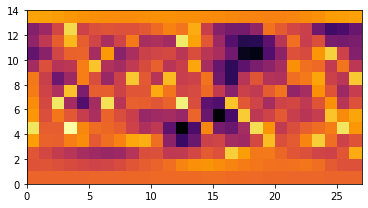

In [3]:
# load input data
input_data = torch.tensor(np.load(path_input_folder / "x_001.npy"))
print('Shape of input_data:', input_data.shape)

# make a quick visualization of one of the radial layers

r_index = 0     # between 0 and 197, where 0 is closest to Earth's core
var_index = 0   # 0 = temperature
                # 1 = vx
                # 2 = vy
                # 3 = vz

fig, ax = plt.subplots(1,1,)
ax.pcolormesh(input_data[0,var_index,r_index,:,:], cmap='inferno')
ax.set_aspect(1)
plt.show()

Next, we'll load the example generator. First, we need to select the "device" to put the generator on (either the CPU or GPU), instantiate the network with PyTorch, and then load the trained generator model.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# instantiate generator
gen = Generator(
    in_chan=4,
    out_chan=4,
    scale_factor=8,
    chan_base=64,
    chan_min=64,
    chan_max=128,
    cat_noise=True,
).to(device)

# load the generator
gen_example = root_dir / 'models/interim/checkpoints' / 'gen_example.pt'

checkpoint = torch.load(gen_example, map_location=torch.device(device))
gen.load_state_dict(checkpoint["gen"])

cuda


<All keys matched successfully>

The `input_data` includes 198 radial layers. However, the input to the generator only requires 30 layers. As such, we'll select 30 equally spaced layers (roughly equally spaced).

In [5]:
index_keep = np.round(
    np.arange(0, input_data.shape[2], input_data.shape[2] / 30.0)
).astype(int)

input_data = input_data[:, :, index_keep, :, :]
print('Shape of input_data:', input_data.shape)

Shape of input_data: torch.Size([1, 4, 30, 14, 27])


We use the `gen_output_slice_for_concatenate` function to create a "fake" slice from the `input_data`. This function takes the full-sized input data (14 x 27) and selects an appropriately sized slice of it to generate the fake output. We can then iterate the `input_data`, using this function, to create a full-sized map.

Let's try it!

In [6]:
def gen_output_slice_for_concatenate(x_input, gen, roll_increment=0, width=32):
    """
    Args:
        x_input (tensor): Input (downsampled) sample.
        gen (pytorch model): Loaded pytorch model
        roll_increment (int): Amount to roll the input by. Standard x_input has width of 27
    """
    x_input = torch.roll(x_input, roll_increment, 4)  # roll if used
    x_input = x_input[:, :, :, :, :10]  # select first 10 points for width
    x_input = pad_data(x_input, pad_top_bot=3, pad_sides=0)  # pad top/bottom

    with torch.no_grad():
        gen.eval()
        x_fake = gen(x_input)

        # x_fake shape: (1, 4, 198, 118, 38)
        return x_fake[:, :, :, :, 3 : width + 3].detach().cpu()

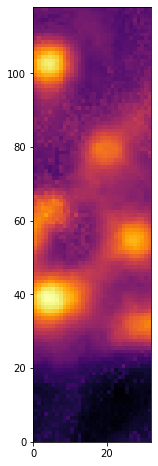

Shape of fake data: torch.Size([1, 4, 198, 118, 32])


In [7]:
# create fake
fake = gen_output_slice_for_concatenate(input_data.to(device), gen, roll_increment=0, width=32)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.pcolormesh(fake[0,var_index,r_index,:,:], cmap='inferno')
ax.set_aspect(1)
plt.show()

print('Shape of fake data:', fake.shape)

The `create_combined_map` function iterates over the above `gen_output_slice_for_concatenate` to produce results that represent the entire Earth.

In [8]:
def create_combined_map(
    x_input, gen, device, r_index, v, final_roll=0, crop=True
):
    fake_dict = {}
    for i, roll_n in enumerate(range(0, 32, 4)):
        fake = gen_output_slice_for_concatenate(
            x_input.to(device), gen, roll_increment=roll_n, width=32
        )
        fake_dict[i] = fake

    for i, k in enumerate(fake_dict):
        if i == 0:
            a = fake_dict[i]
        else:
            a = torch.cat((fake_dict[i], a), axis=-1)

    if crop:
        a = crop_data(
            a,
            crop_height=5,
            crop_width=20,
        )

    color_scheme = "inferno"
    fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    a = torch.roll(a, final_roll, 4)
    ax.pcolormesh(a[0, v, r_index, :, :], cmap=color_scheme)
    ax.set_title(f"Fake (var_index={v}, r_index={r_index})", fontsize=16)
    ax.set_aspect(1)
    plt.show()
    return a

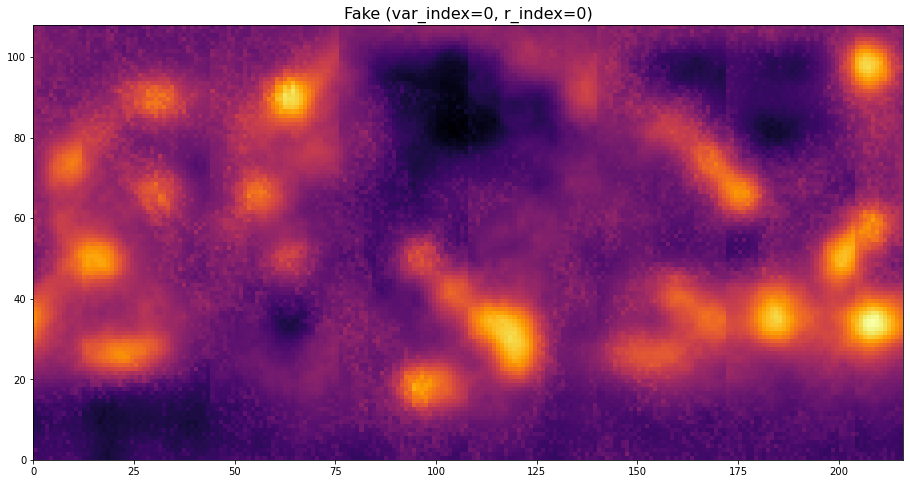

In [9]:
# set the radial layer and variable you want to reproduce

r_index = 0     # between 0 and 197, where 0 is closest to Earth's core
var_index = 0   # 0 = temperature
                # 1 = vx
                # 2 = vy
                # 3 = vz

fake_whole = create_combined_map(input_data, gen, device, r_index, var_index, final_roll=0, crop=True)

A mollweide representation is sometimes nice to look at.

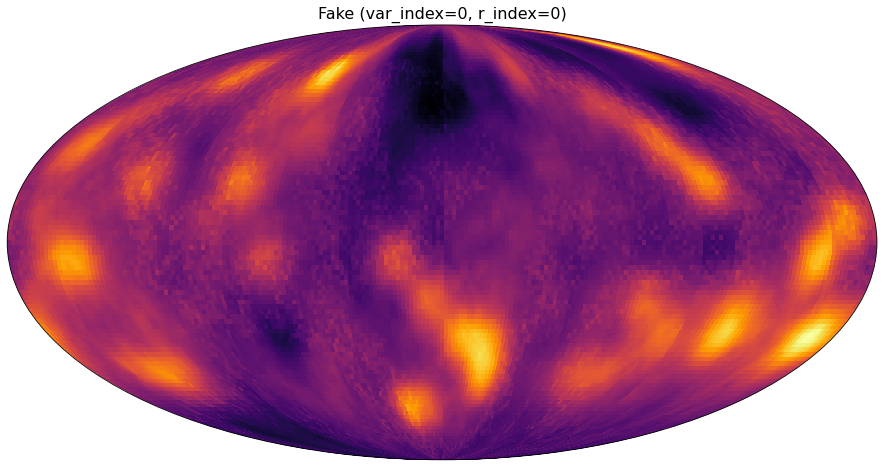

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax = plt.subplot(111, projection="mollweide")

lon = np.linspace(-np.pi, np.pi, 216)
lat = np.linspace(-np.pi / 2.0, np.pi / 2.0, 108)
Lon, Lat = np.meshgrid(lon, lat)

ax.pcolormesh(Lon, Lat, fake_whole[0, var_index, r_index, :, :], cmap='inferno')
ax.set_title(f"Fake (var_index={var_index}, r_index={r_index})", fontsize=16)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

Try different variables and radial indices!

The purpose of this research is to see if we can create a surrogate model of a complex scientific data set and have it run on your average home computer. Of course, we also want the fidelitly of the model to be as accurate as possible. With time, we hope to improve these result. If you're interested, **feel free to help out and offer suggestions**!

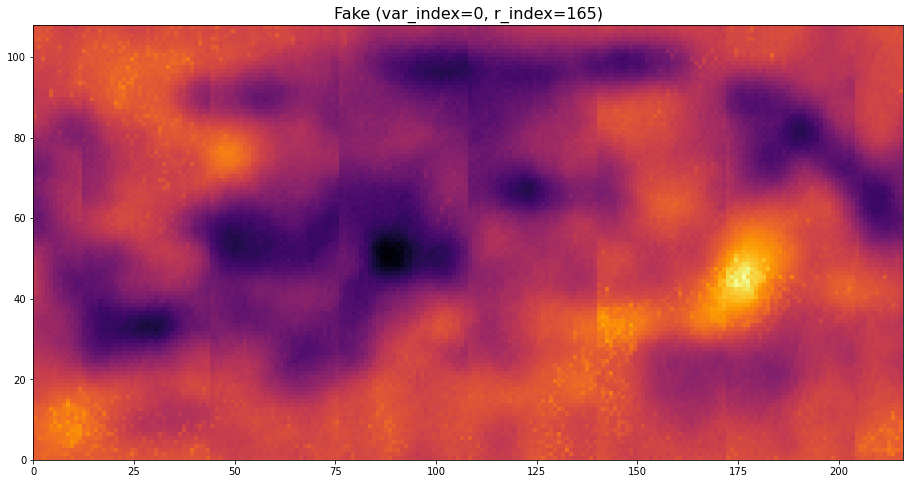

In [11]:
r_index = 165     # between 0 and 197, where 0 is closest to Earth's core
var_index = 0   # 0 = temperature
                # 1 = vx
                # 2 = vy
                # 3 = vz

fake_whole = create_combined_map(input_data, gen, device, r_index, var_index, final_roll=0, crop=True)